In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras
import os,sys, random, cv2
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# random for seed for randamization

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Aug 24 13:41:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ls /content/drive/MyDrive

'Colab Notebooks'
 download.jpg
 dreamstime_s_204492534.jpg
 images.jpg
 k.jpg
 main-qimg-c98238764a199bb93b9804f230d1881c.webp
 Overlap.jpg
 Screenshot-2023-02-08-103141_png_jpg.rf.f42773d366400ac18cad792538d25146.jpg
 Slag-Inclusion.jpg
 stage1_train
 stage1_train.zip
 surface-porosity-300x188.webp
 the-facts-about-weld-porosity-1649054006.jpg
 yolov3


In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)

        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = np.zeros((self.image_size, self.image_size, 1))

        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)

        ## Normalizaing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
!ls /content/drive/MyDrive/stage1_train/

stage1_train


In [ ]:
image_size = 128
train_path = "/content/drive/MyDrive/stage1_train/stage1_train"
epochs = 40
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
train_ids

['0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e',
 '0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93',
 '0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe',
 '0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6',
 '0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0',
 '0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2',
 '0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c',
 '0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c',
 '0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37',
 '0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e',
 '0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e',
 '0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3',
 '0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f',
 '0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1',
 '1a11552569160f0b1ea10bedbd628ce6

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape),print(len(x))


(8, 128, 128, 3) (8, 128, 128, 1)
8


(None, None)

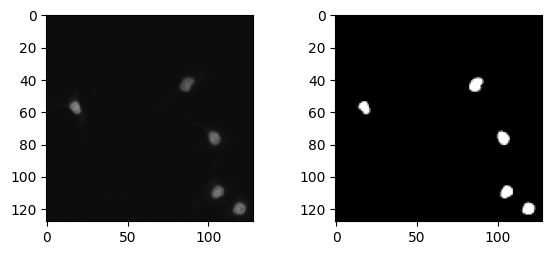

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y[r],(image_size, image_size)),cmap = "gray")

**# down , up and base of UNet**

In [ ]:
def down_block(x, filters, kernel_size= (3,3), padding = "same", strides =1 ):
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides)(c)
  p = keras.layers.MaxPool2D((2,2), (2,2))(c)

  return c, p

def up_block(x, skip, filters, kernel_size = (3,3), padding= "same", strides = 1):
  us = keras.layers.UpSampling2D((2,2))(x)
  concat = keras.layers.Concatenate()([us, skip])
  c = keras.layers.Conv2D(filters, kernel_size , padding = padding, strides = strides)(concat)
  c = keras.layers.Conv2D(filters, kernel_size , padding = padding, strides = strides)(c)

  return c


def bottleneck(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides)(c)

  return c






# UNet Model

In [ ]:
def UNet():
  f = [16, 32, 64, 128, 256]

  inputs = keras.layers.Input((image_size, image_size,3))

  p0 = inputs
  c1, p1 = down_block(p0, f[0])
  c2, p2 = down_block(p1, f[1])
  c3, p3 = down_block(p2, f[2])
  c4, p4 = down_block(p3, f[3])

  bn = bottleneck(p4, f[4])


  u1 = up_block(bn, c4, f[3])
  u2 = up_block(u1, c3, f[2])
  u3 = up_block(u2,c2, f[1])
  u4 = up_block(u3, c1, f[0])


  outputs = keras.layers.Conv2D(1, (1,1), padding="same", activation = "sigmoid")(u4)

  model = keras.models.Model(inputs, outputs)

  return model





In [ ]:

model = UNet()
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

# Training the model

In [ ]:
train_gen = DataGen(train_ids, train_path, batch_size = batch_size, image_size = image_size)
valid_gen = DataGen(valid_ids, train_path, batch_size = batch_size, image_size = image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size




In [ ]:
model.fit(train_gen, validation_data = valid_gen, steps_per_epoch = train_steps, validation_steps = valid_steps, epochs = epochs  )

Epoch 1/40
15/15 [==============================] - 3051s 200s/step - loss: 1.3164 - acc: 0.7073 - val_loss: 0.5698 - val_acc: 0.7897
Epoch 2/40
15/15 [==============================] - 18s 1s/step - loss: 0.6121 - acc: 0.8251 - val_loss: 0.7415 - val_acc: 0.7610
Epoch 3/40
15/15 [==============================] - 17s 1s/step - loss: 0.6380 - acc: 0.7697 - val_loss: 0.6973 - val_acc: 0.7543
Epoch 4/40
15/15 [==============================] - 17s 1s/step - loss: 0.4998 - acc: 0.8380 - val_loss: 0.8155 - val_acc: 0.7610
Epoch 5/40
15/15 [==============================] - 17s 1s/step - loss: 0.4535 - acc: 0.8364 - val_loss: 0.4996 - val_acc: 0.7610
Epoch 6/40
15/15 [==============================] - 17s 1s/step - loss: 0.4247 - acc: 0.8381 - val_loss: 0.5213 - val_acc: 0.7610
Epoch 7/40
15/15 [==============================] - 17s 1s/step - loss: 0.4091 - acc: 0.8417 - val_loss: 0.5257 - val_acc: 0.7610
Epoch 8/40
15/15 [==============================] - 17s 1s/step - loss: 0.4072 - acc: 

# Model test


In [ ]:
model.save_weights("UNet.h5")

# data for pred

x, y = valid_gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5

1/1 [==============================] - 0s 205ms/step


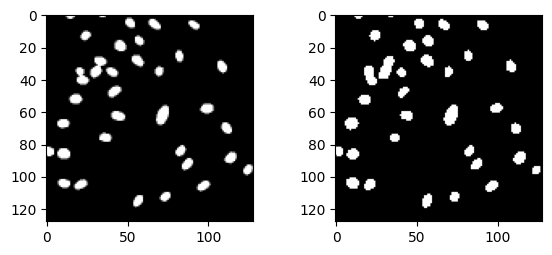

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

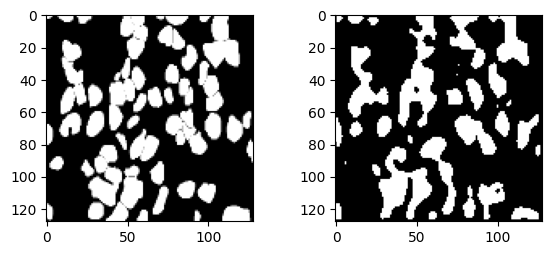

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")